In [101]:
!brew install libomp
!poetry add xgboost

==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Homebrew collects anonymous analytics.
Read the analytics documentation (and how to opt-out) here:
  https://docs.brew.sh/Analytics
No analytics have been recorded yet (nor will be during this `brew` run).

==> Homebrew is run entirely by unpaid volunteers. Please consider donating:
  https://github.com/Homebrew/brew#donations

==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
ad                  ggh                 libpostal-rest      sql-formatter
adapterremoval      git-mob             mac                 symfony-cli
arelo               go@1.23             md2pdf              threatcl
bacon-ls            gomi                mummer              vfkit
bagels              hcledit             nping               yamlfix
bazel@7             identme  

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from typing import Tuple

from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder
import xgboost as xgb
from sklearn.calibration import calibration_curve

In [64]:
data_path = '../../aws/data/feature_frame.csv'
df = pd.read_csv(data_path)

In [65]:
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [67]:
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col = 'outcome'
feature_cols = [col for col in df.columns if col not in info_cols + [label_col]]

categorical_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = [col for col in feature_cols if col not in categorical_cols + binary_cols]

In [68]:
#quedarnos solo con 5 ordenes de 5 o mas productos
def push_relevant_dataframe(df: pd.DataFrame, min_products: int = 5 ) -> pd.DataFrame:
    """We are only interested in big enough orders that are profitable"""
    order_size = df.groupby("order_id").outcome.sum()
    orders_of_min_size = order_size[order_size >= min_products].index
    return df.loc[lambda x: x.order_id.isin(orders_of_min_size)]


df_selected = (
    df.pipe(push_relevant_dataframe)
    .assign(created_at=lambda x: pd.to_datetime(x.created_at))
    .assign(order_date=lambda x: pd.to_datetime(x.order_date).dt.date)
)

In [69]:
df_selected.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [70]:
df.order_id.nunique() > df_selected.order_id.nunique()

True

Vamos a asegurarnos de que las ordenes no estan divididas en train y validación (la orden entera tiene que estar o en train o validación). 

Además, vamos a hacer temporal split.

In [71]:
daily_orders = df_selected.groupby('order_date').order_id.nunique()

In [72]:
daily_orders.head()

order_date
2020-10-05     3
2020-10-06     7
2020-10-07     6
2020-10-08    12
2020-10-09     4
Name: order_id, dtype: int64

In [73]:
cumsum_daily_orders = daily_orders.cumsum() / daily_orders.sum()

train_val_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.7].idxmax()
val_test_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.9].idxmax()

print("Train since:", cumsum_daily_orders.index.min())
print("Train until:", train_val_cutoff)
print("Val until:", val_test_cutoff)
print("Test until:", cumsum_daily_orders.index.max())

Train since: 2020-10-05
Train until: 2021-02-04
Val until: 2021-02-22
Test until: 2021-03-03


In [74]:
train_df = df_selected[df_selected.order_date <= train_val_cutoff]
val_df = df_selected[
    (df_selected.order_date >= train_val_cutoff)
    & (df_selected.order_date <= val_test_cutoff)
]
test_df = df_selected[df_selected.order_date > val_test_cutoff]

## Baseline

Como ya hemos entrenado un modelo lineal en el anterior modulo que mejora el baseline inicial, vamos a definir el modelo lineal con 4 features como baseline 

In [75]:
def plot_metrics(
        model_name: str,
        y_pred: pd.Series,
        y_test: pd.Series,
        figure: Tuple[matplotlib.figure.Figure, np.array] = None
):
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig, ax = figure
        
        
    ax[0].plot(recall_, precision_, label=f"{model_name}; AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(f"Precision-recall curve")
    ax[0].legend()

    ax[1].plot(fpr, tpr, label=f"AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f"ROC curve")
    ax[1].legend()
    

In [76]:
def feature_label_split(df: pd.DataFrame, label_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop(label_col, axis=1), df[label_col]

X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)
X_test, y_test = feature_label_split(test_df, label_col)

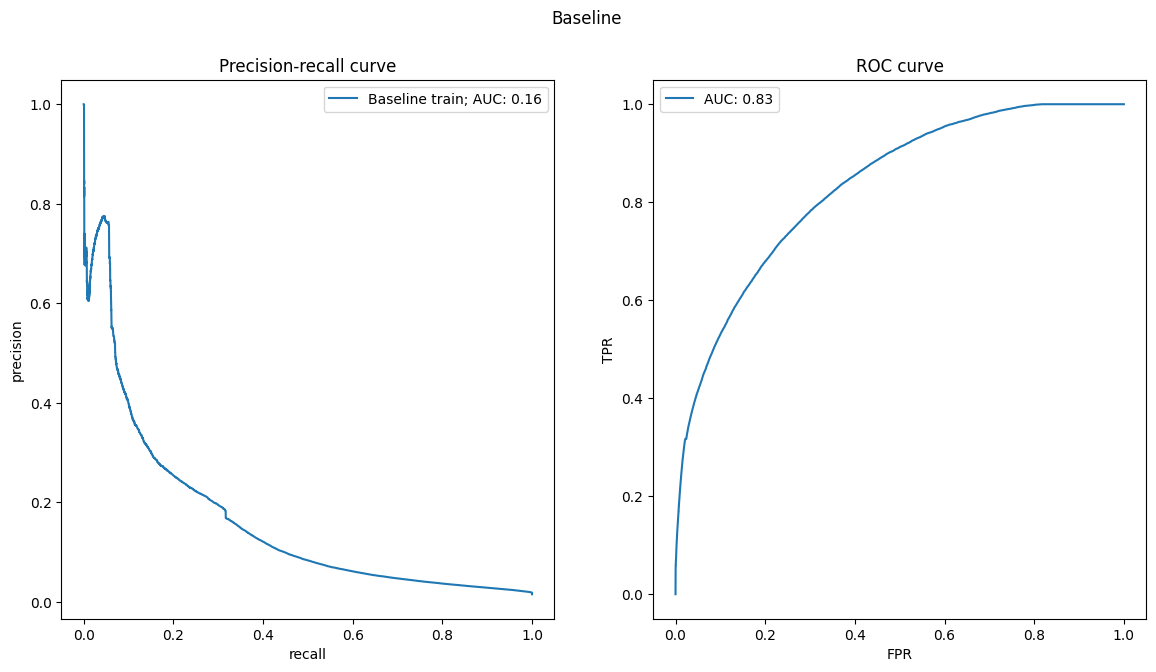

In [77]:
reduced_cols = ["ordered_before", "abandoned_before", "global_popularity"]

fig1, ax1 = plt.subplots(1,2, figsize=(14,7))
fig1.suptitle("Baseline")

lr =make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", C=1e-6))

lr.fit(X_train[reduced_cols], y_train)
lr_train_proba = lr.predict_proba(X_train[reduced_cols])[:, 1]

lr.fit(X_val[reduced_cols], y_val)
lr_val_proba = lr.predict_proba(X_val[reduced_cols])[:, 1]

plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test= train_df[label_col], figure=(fig1, ax1)
)

# Decision trees

Una vez definido el baseline, voy a empezar con decision trees con todas las features (menos categoricas).

In [78]:
train_cols = numerical_cols + binary_cols

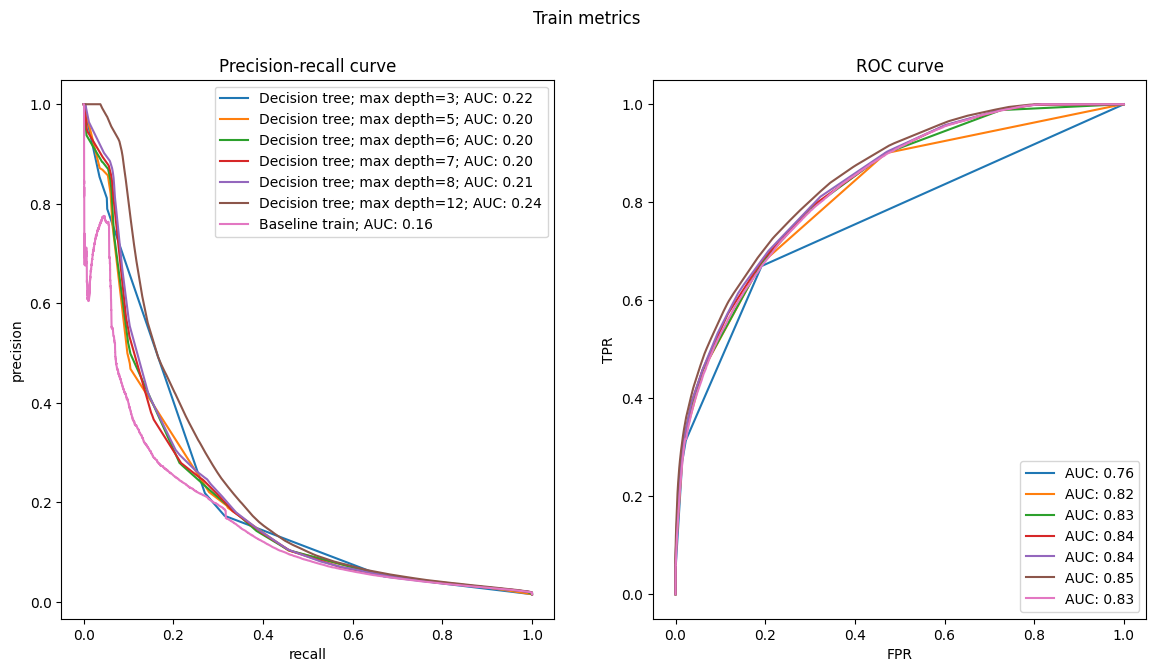

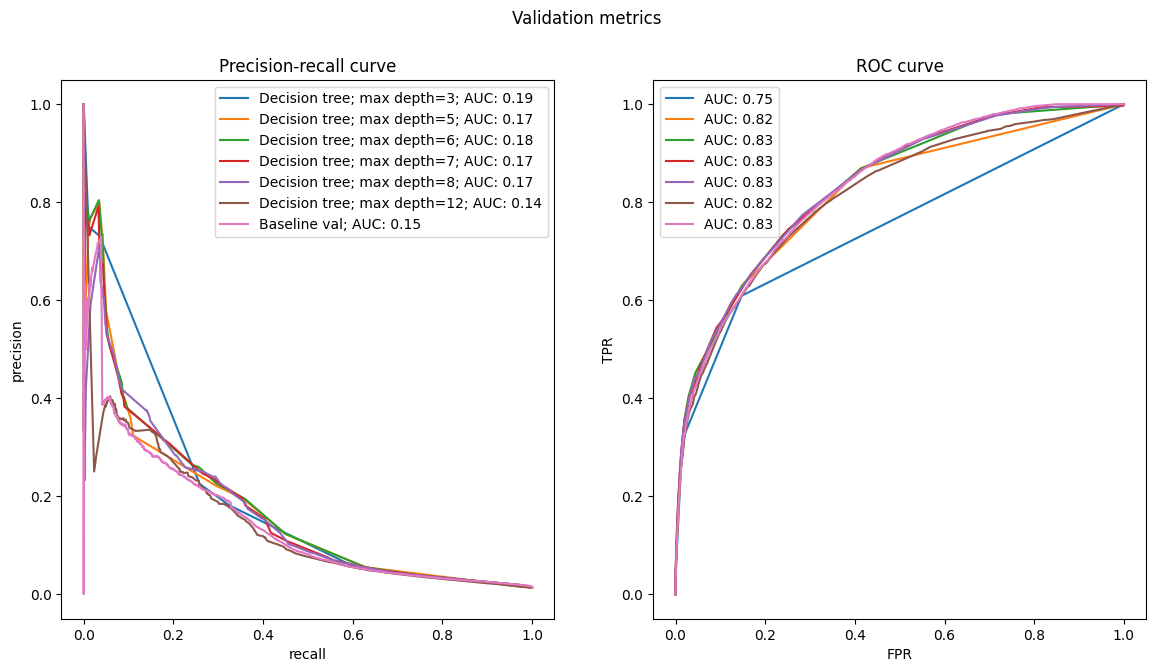

In [79]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")


max_depth = [3, 5, 6, 7, 8, 12]
for m_d in max_depth:
    dt = make_pipeline(
        DecisionTreeClassifier(max_depth=m_d)
    )
    dt.fit(X_train[train_cols], y_train)
    dt_train_proba = dt.predict_proba(X_train[train_cols])[:, 1]
    plot_metrics(
        f"Decision tree; max depth={m_d}", y_pred=dt_train_proba, y_test=train_df[label_col], figure=(fig1,ax1)
    )

    dt_val_proba = dt.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"Decision tree; max depth={m_d}", y_pred=dt_val_proba, y_test=val_df[label_col], figure=(fig2,ax2)
    )


plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test= train_df[label_col], figure=(fig1, ax1)
)

plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test= val_df[label_col], figure=(fig2, ax2)
)



Arboles con poca profundidad en vez de presentar una curva presentan "segmentos rectos", esto se debe a la naturaleza de los arboles de decisión, ya que generan predicciones discretas en vez de continuas, al cambiar el umbral para calcular las curvas, muchos puntos se actualizan a la vez, lo que genera estos segmentos (?)

Arboles con mucha profundidad hacen mucho overfit.

Un punto medio es lo recomendado en este caso, profundidad 6

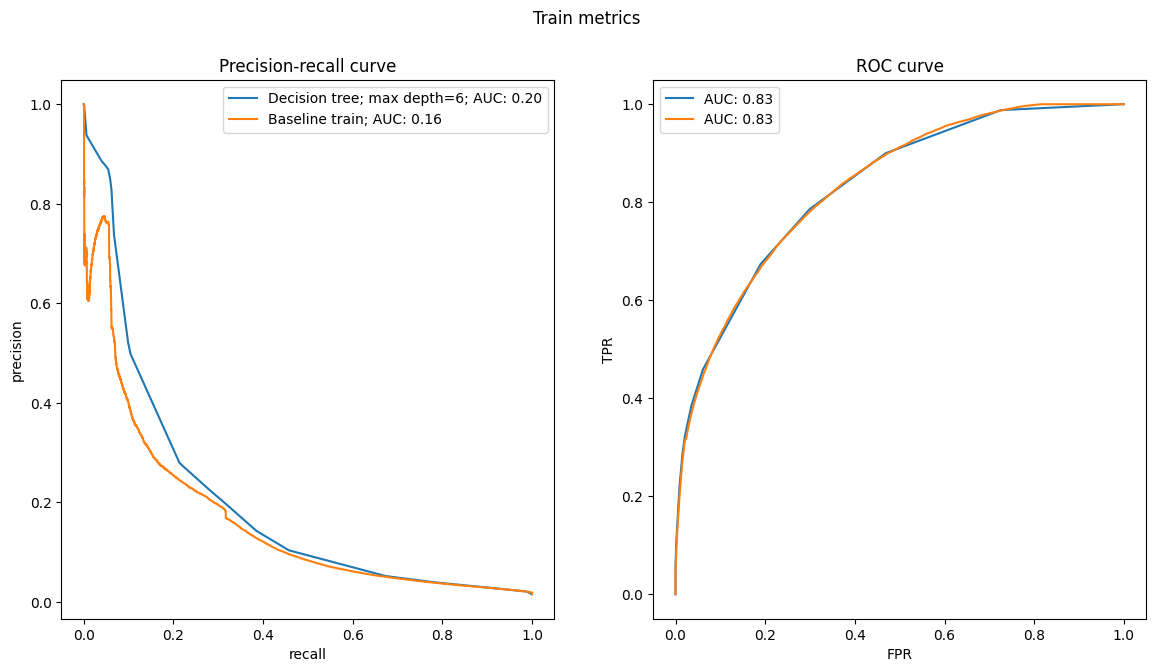

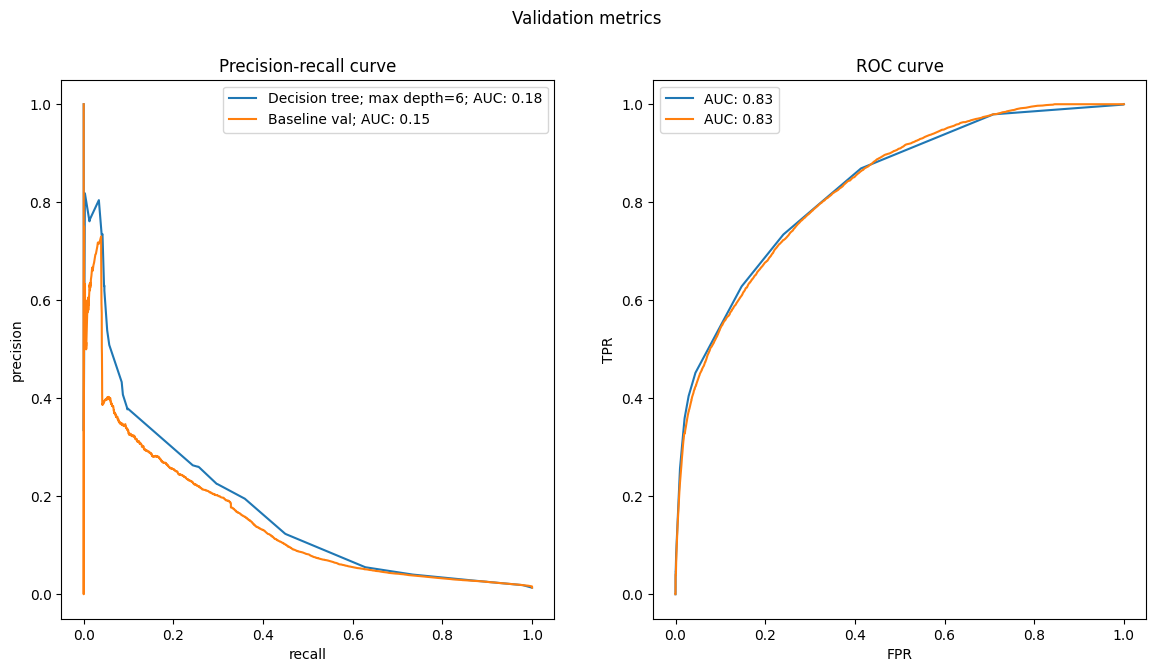

In [80]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

selected_max_depth = 6

selected_dt = make_pipeline(
    DecisionTreeClassifier(max_depth=selected_max_depth)
)
selected_dt.fit(X_train[train_cols], y_train)
dt_train_proba = selected_dt.predict_proba(X_train[train_cols])[:, 1]
plot_metrics(
    f"Decision tree; max depth={selected_max_depth}", y_pred=dt_train_proba, y_test=train_df[label_col], figure=(fig1,ax1)
)

dt_val_proba = selected_dt.predict_proba(X_val[train_cols])[:, 1]
plot_metrics(
    f"Decision tree; max depth={selected_max_depth}", y_pred=dt_val_proba, y_test=val_df[label_col], figure=(fig2,ax2)
)

plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test= train_df[label_col], figure=(fig1, ax1)
)
plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test= val_df[label_col], figure=(fig2, ax2)
)

Vamos a incluir ahora las variables categoricas

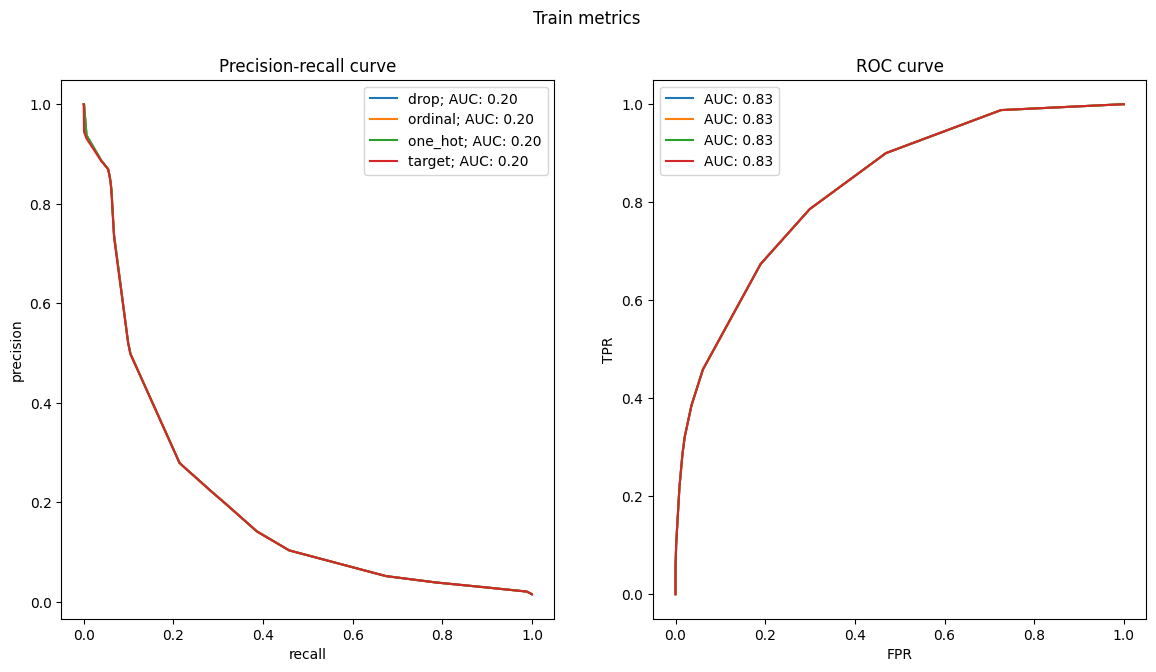

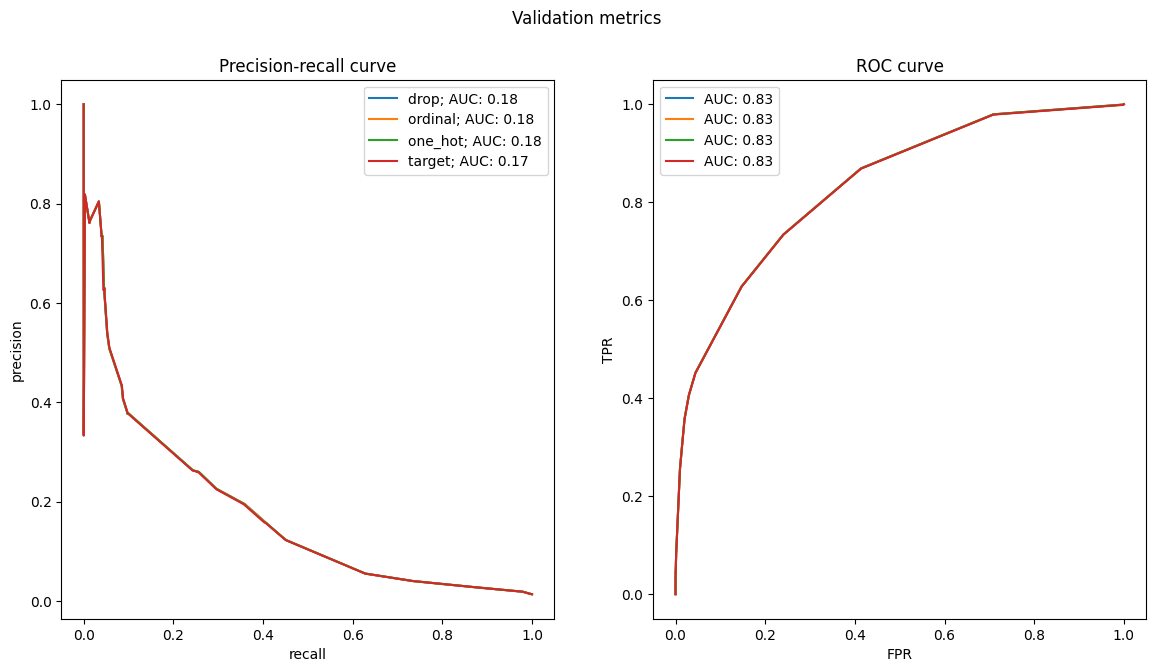

In [81]:
extended_cols = train_cols + categorical_cols

categorical_preprocessors = [
    ("drop", "drop"),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    ("one_hot", OneHotEncoder(handle_unknown="ignore", max_categories=20, sparse_output=False),),
    ("target", TargetEncoder(target_type="continuous"))
]

fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")


for name, categorical_preprocessor in categorical_preprocessors:
    preprocessor = ColumnTransformer(
        [
            ("numerical", "passthrough", train_cols),
            ("categorical", categorical_preprocessor, categorical_cols)
        ]
    )
    extended_dt = make_pipeline(
        preprocessor, DecisionTreeClassifier(max_depth=selected_max_depth)
    )

    extended_dt.fit(X_train[extended_cols], y_train)
    extended_dt_train_proba = extended_dt.predict_proba(X_train[extended_cols])[:, 1]
    plot_metrics(
        name, y_pred=extended_dt_train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
    )

    extended_dt_val_proba = extended_dt.predict_proba(X_val[extended_cols])[:, 1]
    plot_metrics(name, y_pred=extended_dt_val_proba, y_test=val_df[label_col], figure=(fig2, ax2))

Me parece muy raro que los 4 metodos funcionen exactamente igual, fallo en codigo (?), creo que no.

Otra opción es que aporten tan poco valor que no afectan y por eso son iguales

# Random Forest

Primero quiero ver lo que comentabamos en clase de que debido a la naturaleza de Random Forest, el error en train puede ser 0 ya que construimos hasta el final cada arbol, y como cada muestra esta en aprox un 66% de los arboles, minimo un 66% de los arboles predicen bien cada muestra (error=0) y como es mayoria , el error del Ensemble va a ser 0.

Cada arbol se construya con profundidad máxima, ya que reduce el sesgo. Añadiendo arboles, reducimos la varianza, lo cual da lugar a un error con poco sesgo y poca varianza.



***Tengo una duda a la que he dado muchas vueltas y no consigo encontrar la respuesta***; Respecto a los threshold con los que calculamos las curvas:

¿Los threshold aplican a cada arbol individual o al ensemble? Me explico

Una forma que tengo de ver el threshold es a nivel de arbol, es decir que aplico el threshold para decidir cual es la decisión de mi arbol en cada hoja (en este caso, como construyo arboles hasta el final, da igual el threshold, ya que solo vamos a tener una muestra y la proporción va a ser o 100% o 0% y va a clasificar como 0 o 1 indiferentemente del umbral) 

Esto tiene sentido en mi cabeza, lo que pasa es que, lo que comentaba antes de que el error de entrenamiento puede ser 0 cuando entrenamos con profundidad maxima, lo que entendi en clase es que como minimo un 66% de los arboles predicen bien cada muestra, esto es mayoria y el Ensemble lo va a clasificar bien y el error es 0. Cuando decimos que es mayoria, es porque establecemos un threshold a 0.5 y por eso 0.66>0.5 . Ahi viene mi duda, este threshold del ensemble existe? En mi cabeza si deberia de existir, ya que si el resultado de un ensemble es que 6 arboles predicen clase 1 y 4 arboles predicen clase 0, tengo P(1)=0.6 y p(0)=0.4 y si mi threshold del ensemble es 0.5 estoy clasificando esa muestra como 1 y si es 0.7 la clasifico como 0. De la misma forma, ese threshold del ensemble afetaria al 66%. En caso de que 66% de mis arboles clasifiquen bien y 34% restante clasifiquen mal y ponga mi threshold en 0.7, el ensemble no lo clasificaria bien y el error ya no seria 0?

¿Existe ese threshold del ensemble? En caso de existir, cuando calculamos curvas ROC, los threshold aplican tanto para cada arbol como para el ensemble? 

Es algo que me lia mucho, igual me estoy complicando pero me gustaria que me quedara claro, me dices con lo que opines!

In [ ]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [25, 50, 100, 200]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2
)

grid_search.fit(X_train[train_cols], train_df[label_col])

In [89]:
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor puntuación (AUC-ROC):", grid_search.best_score_)

Mejores hiperparámetros: {'n_estimators': 50}
Mejor puntuación (AUC-ROC): 0.41285675580268394


[Train] Random Forest (n_estimators=50) -> ROC AUC: 0.9955, PR AUC: 0.8593
[Validation] Random Forest (n_estimators=50) -> ROC AUC: 0.7490, PR AUC: 0.1507


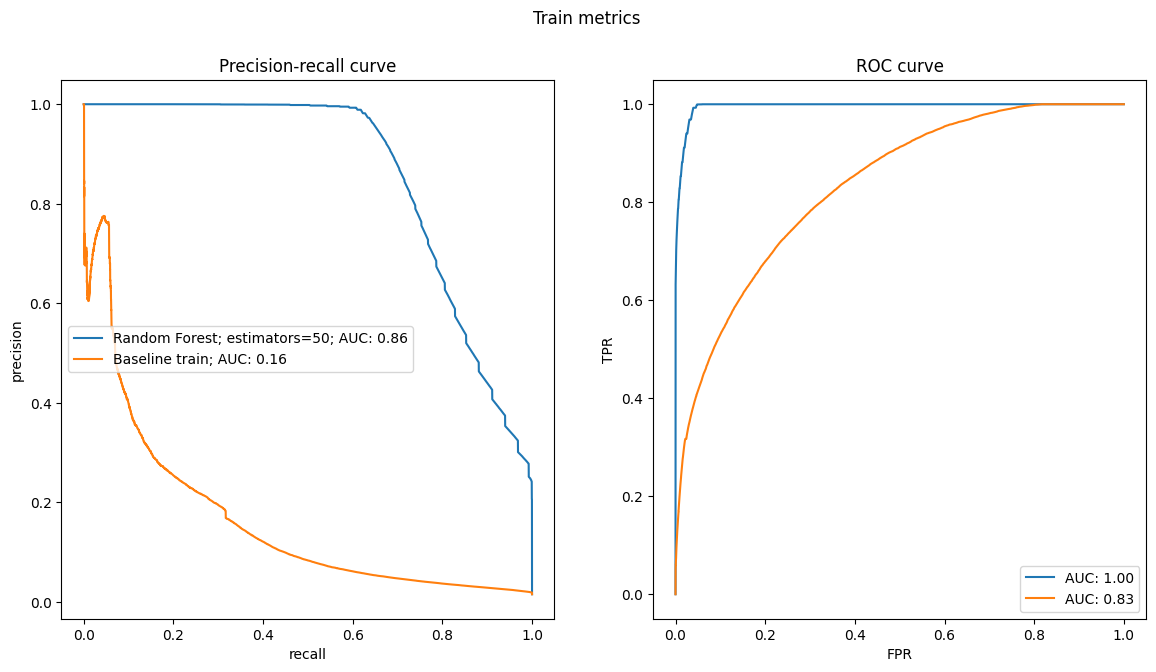

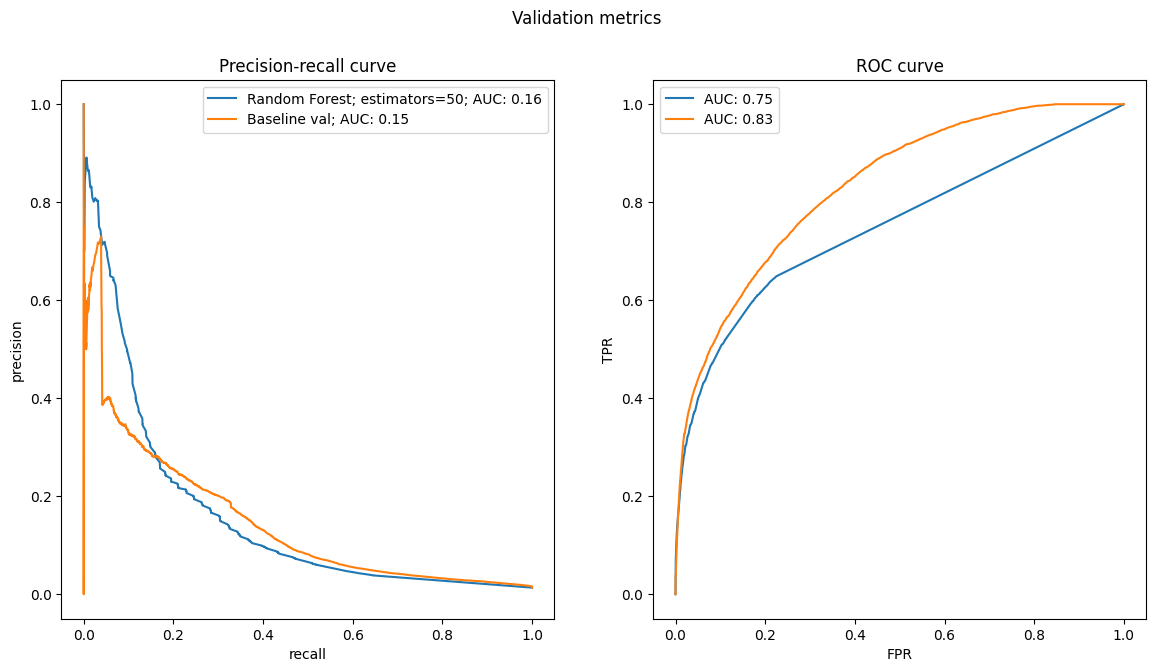

In [92]:
from sklearn.metrics import roc_auc_score, average_precision_score


fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")


n_est = 50

rf = make_pipeline(
    RandomForestClassifier(n_estimators= n_est)
)
rf.fit(X_train[train_cols], y_train)
rf_train_proba = rf.predict_proba(X_train[train_cols])[:, 1]
plot_metrics(
    f"Random Forest; estimators={n_est}", y_pred=rf_train_proba, y_test=train_df[label_col], figure=(fig1,ax1)
)

rf_val_proba = rf.predict_proba(X_val[train_cols])[:, 1]
plot_metrics(
    f"Random Forest; estimators={n_est}", y_pred=rf_val_proba, y_test=val_df[label_col], figure=(fig2,ax2)
)


plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test= train_df[label_col], figure=(fig1, ax1)
)

plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test= val_df[label_col], figure=(fig2, ax2)
)


roc_auc_train = roc_auc_score(train_df[label_col], rf_train_proba)
pr_auc_train = average_precision_score(train_df[label_col], rf_train_proba)
print(f"[Train] Random Forest (n_estimators={n_est}) -> ROC AUC: {roc_auc_train:.4f}, PR AUC: {pr_auc_train:.4f}")

roc_auc_val = roc_auc_score(val_df[label_col], rf_val_proba)
pr_auc_val = average_precision_score(val_df[label_col], rf_val_proba)
print(f"[Validation] Random Forest (n_estimators={n_est}) -> ROC AUC: {roc_auc_val:.4f}, PR AUC: {pr_auc_val:.4f}")

Claramente es un modelo muy malo, pero que el baseline, pero sirve para entender como funciona Random Forest


La curva precision-recall si se ve ese threshold del ensemble que comentaba antes (?)

Y en la curva ROC se veria muy a la izquierda del eje x ( por eso en problemas desbalanceados decimos que la curva ROC no es tan util, porque aunque crezcan los FP, al haber tantisimas etiquetas =0, no nos vamos a desplazar a lo largo del eje x) (?)


-------------------

Voy a probar otro Random Forest, ahora controlando profundidad.

In [83]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 300],
    'max_depth': [4, 7, None],
    'min_samples_split': [4, 8],
    'min_samples_leaf': [2, 4]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2
)

grid_search.fit(X_train[train_cols], train_df[label_col])

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   8.0s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   8.5s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   8.4s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=  15.6s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=  16.1s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=  16.9s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=  47.3s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=  48.3s
[CV] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=  50.0s
[CV] END max_depth=4, min_samples_leaf=2,

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 7, None], 'min_samples_leaf': [2, 4],
                         'min_samples_split': [4, 8],
                         'n_estimators': [50, 100, 300]},
             scoring='roc_auc', verbose=2)

In [84]:
train_cols = numerical_cols + binary_cols

In [ ]:
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor puntuación (AUC-ROC):", grid_search.best_score_)


Mejores hiperparámetros: {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 50}
Mejor puntuación (AUC-ROC): 0.8302371774059504


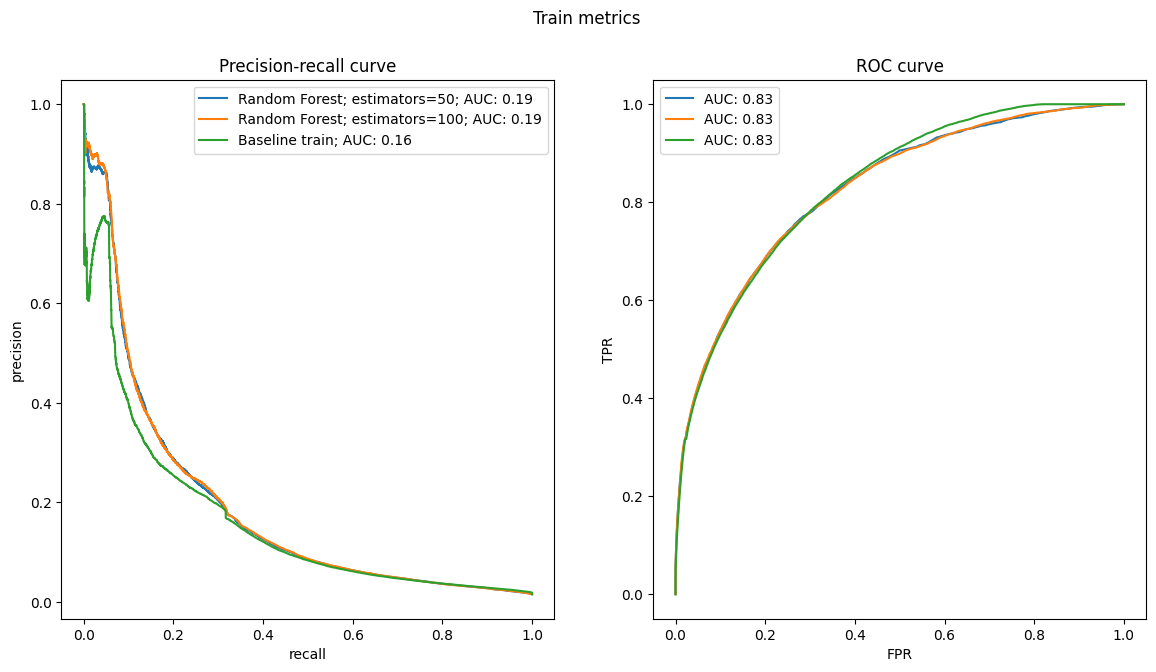

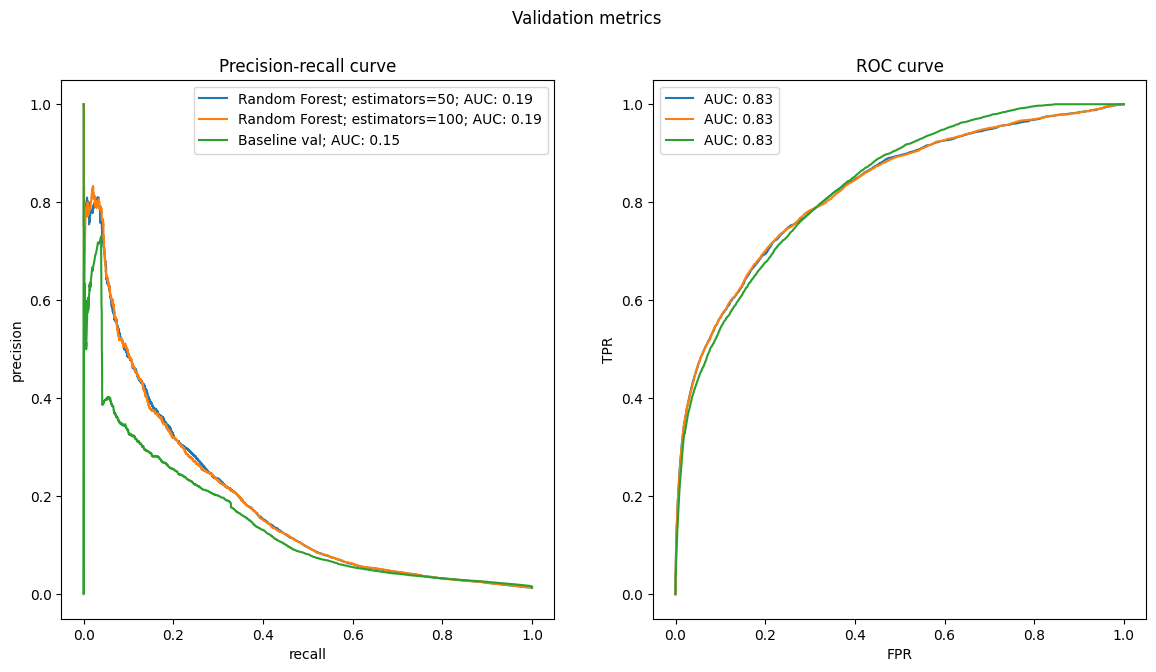

In [102]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")


n_estimators = [50, 100]
max_depth_ = 4
min_samples_split_ = 4
min_samples_leaf_ = 4
for n_esti in n_estimators:
    rf = make_pipeline(
        RandomForestClassifier(n_estimators= n_esti, max_depth=max_depth_, min_samples_split=min_samples_split_, min_samples_leaf=min_samples_leaf_)
    )
    rf.fit(X_train[train_cols], y_train)
    rf_train_proba = rf.predict_proba(X_train[train_cols])[:, 1]
    plot_metrics(
        f"Random Forest; estimators={n_esti}", y_pred=rf_train_proba, y_test=train_df[label_col], figure=(fig1,ax1)
    )

    rf_val_proba = rf.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"Random Forest; estimators={n_esti}", y_pred=rf_val_proba, y_test=val_df[label_col], figure=(fig2,ax2)
    )


plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test= train_df[label_col], figure=(fig1, ax1)
)

plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test= val_df[label_col], figure=(fig2, ax2)
)

Este modelo funciona algo mejor

Vamos a comprobar ahora feature importance

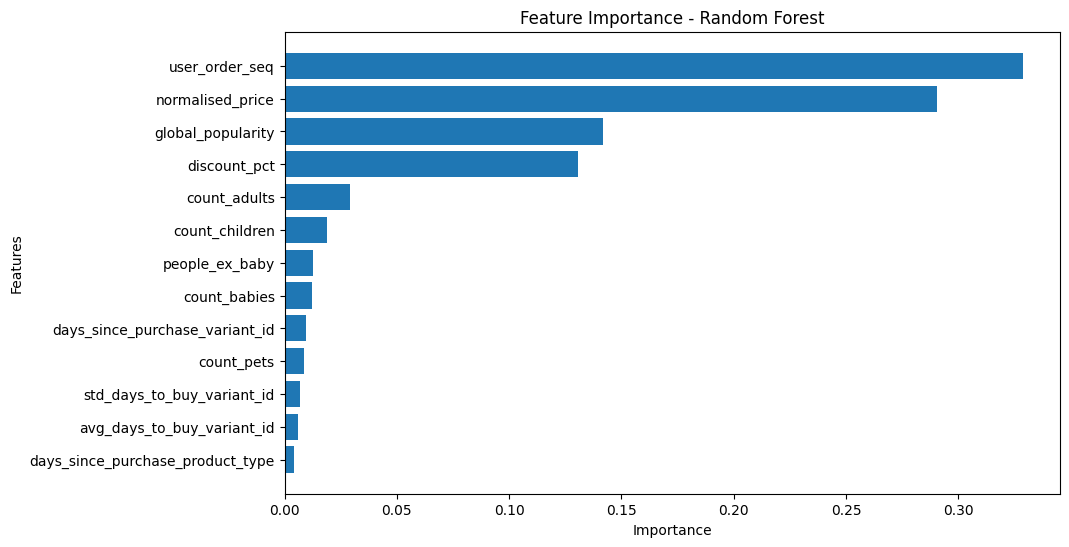

In [119]:
importances = rf.named_steps['randomforestclassifier'].feature_importances_
feature_names = X_train[train_cols].columns
indices = np.argsort(importances)


plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Random Forest")
plt.barh(range(len(importances)), importances[indices], align="center")
plt.yticks(range(len(importances)), feature_names[indices])

plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

Al haber tantas features de poca calidad, puede dar lugar a arboles malos. Como cada arbol recibe un subconjunto de features, va a haber arboles con features malas y van a ser malos arboles. Voy a probar a entrenar con el top 13 de features.

In [107]:
top_13_features = feature_names[indices][:13]

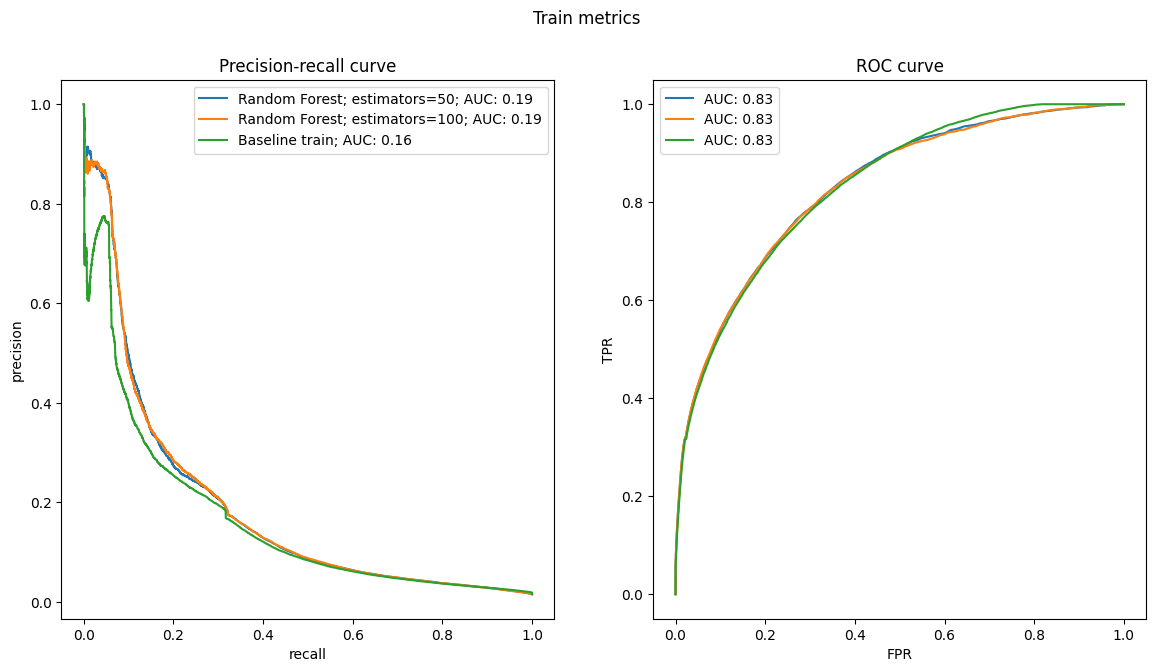

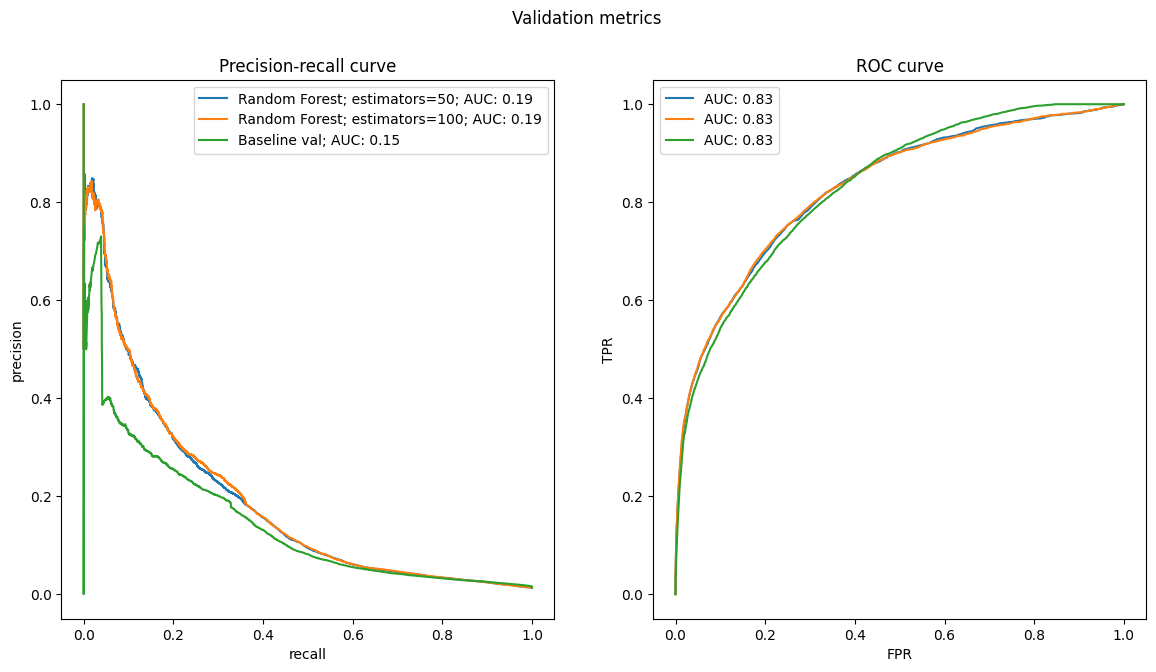

In [108]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")


n_estimators = [50, 100]
max_depth_ = 4
min_samples_split_ = 4
min_samples_leaf_ = 4
for n_esti in n_estimators:
    rf = make_pipeline(
        RandomForestClassifier(n_estimators= n_esti, max_depth=max_depth_, min_samples_split=min_samples_split_, min_samples_leaf=min_samples_leaf_)
    )
    rf.fit(X_train[top_13_features], y_train)
    rf_train_proba = rf.predict_proba(X_train[top_13_features])[:, 1]
    plot_metrics(
        f"Random Forest; estimators={n_esti}", y_pred=rf_train_proba, y_test=train_df[label_col], figure=(fig1,ax1)
    )

    rf_val_proba = rf.predict_proba(X_val[top_13_features])[:, 1]
    plot_metrics(
        f"Random Forest; estimators={n_esti}", y_pred=rf_val_proba, y_test=val_df[label_col], figure=(fig2,ax2)
    )


plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test= train_df[label_col], figure=(fig1, ax1)
)

plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test= val_df[label_col], figure=(fig2, ax2)
)

En este caso los resultados son los mismos que con todas las features, un motivo puede ser que Random Forest ya estaba "regularizando" mediante profundidad y por eso esta "regularización" extra de features no aporte.

Si el rendimiento es el mismo, es deseable quedarnos con el de menos features: entrena más rapido, menos consultas a base de datos (más barato), hace inferencia más rapido

Random Forest mejora el baseline de modelo lineal. Vamos a probar ahora otro modelo no lineal, en este caso de Boosting en vez de Bagging.

# Gradient Boosting trees

Los hiperparametros afectan mucho

In [131]:
train_cols = numerical_cols + binary_cols

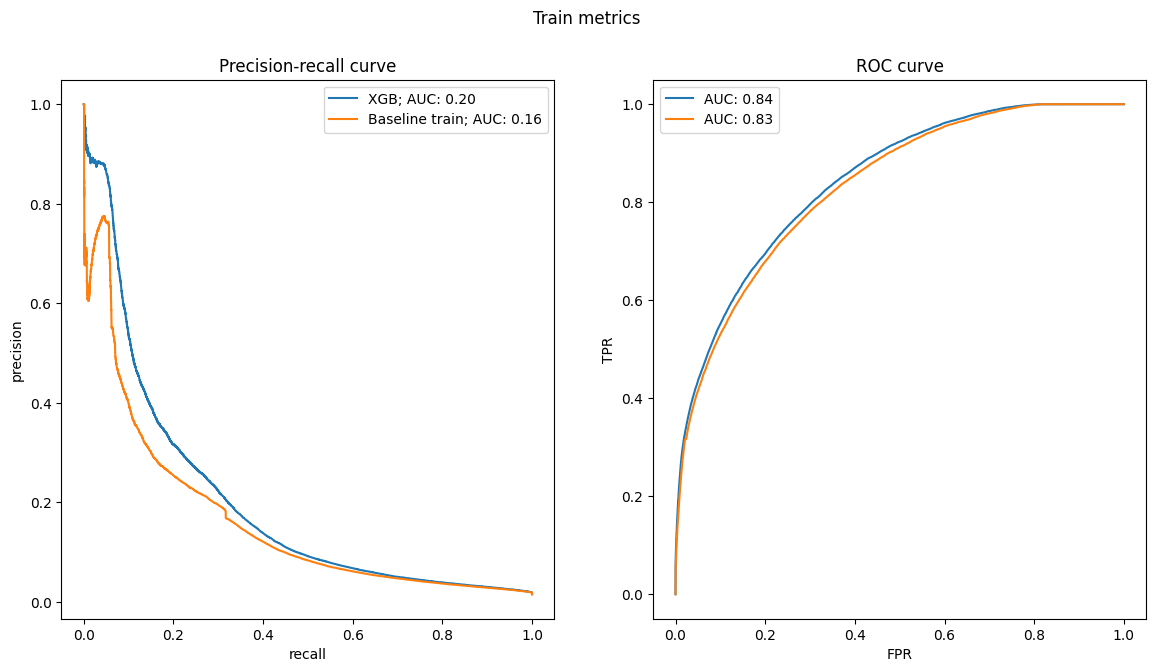

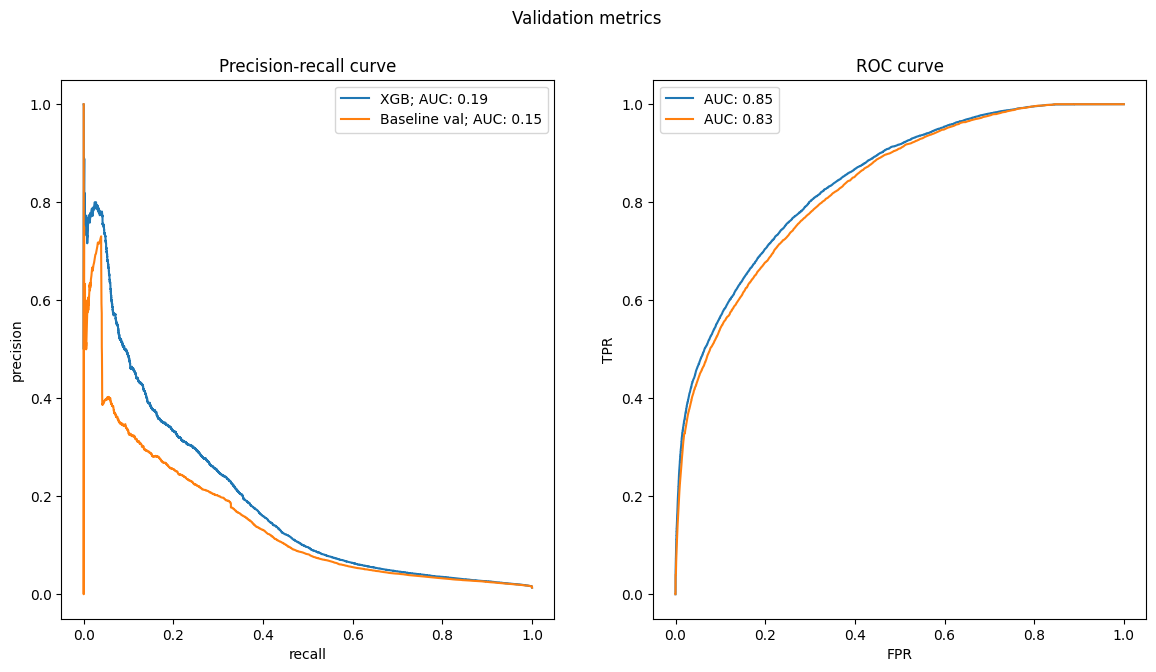

In [132]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")


xg = make_pipeline(
    xgb.XGBClassifier(
    objective='binary:logistic',  
    n_estimators=100,            
    max_depth=3,                 
    learning_rate=0.1,         
    subsample=0.8,            
    colsample_bytree=0.8         
)
)

xg.fit(X_train[train_cols], y_train)
xg_train_proba = xg.predict_proba(X_train[train_cols])[:, 1]
plot_metrics(
    f"XGB", y_pred=xg_train_proba, y_test=train_df[label_col], figure=(fig1,ax1)
)

xg_val_proba = xg.predict_proba(X_val[train_cols])[:, 1]
plot_metrics(
    f"XGB", y_pred=xg_val_proba, y_test=val_df[label_col], figure=(fig2,ax2)
)


plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test= train_df[label_col], figure=(fig1, ax1)
)

plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test= val_df[label_col], figure=(fig2, ax2)
)

In [133]:
print(xg.named_steps)


{'xgbclassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)}


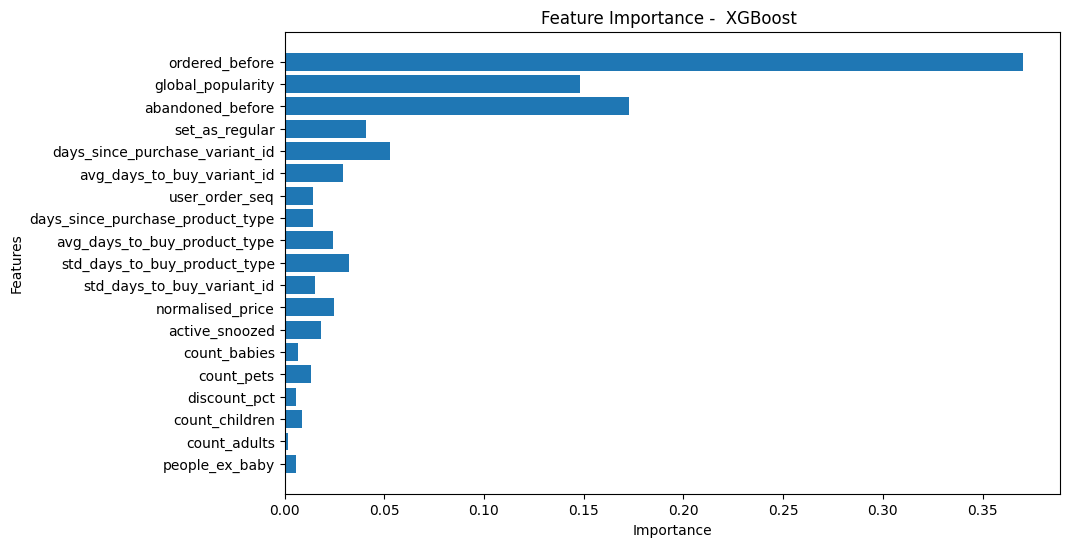

In [135]:
importances_xg = xg.named_steps['xgbclassifier'].feature_importances_
feature_names_xg = X_train[train_cols].columns
indices_xg = np.argsort(importances)


plt.figure(figsize=(10, 6))
plt.title("Feature Importance -  XGBoost ")
plt.barh(range(len(importances_xg)), importances_xg[indices_xg], align="center")
plt.yticks(range(len(importances_xg)), feature_names_xg[indices_xg])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [136]:
top_20_features_xg = feature_names_xg[indices_xg][:20]

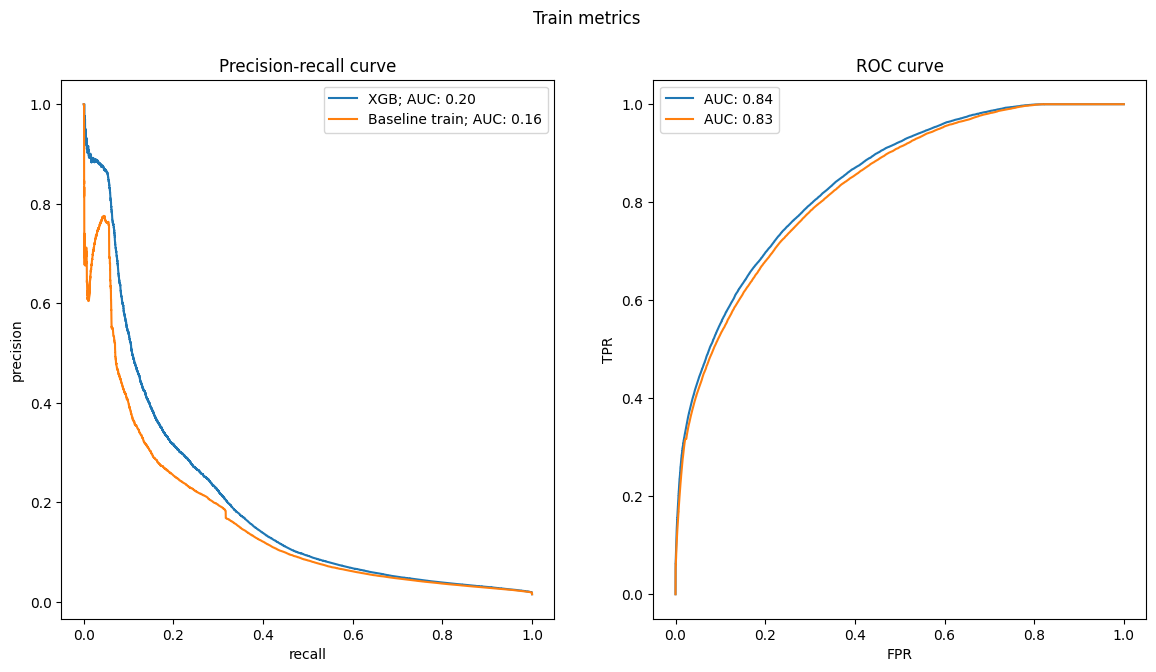

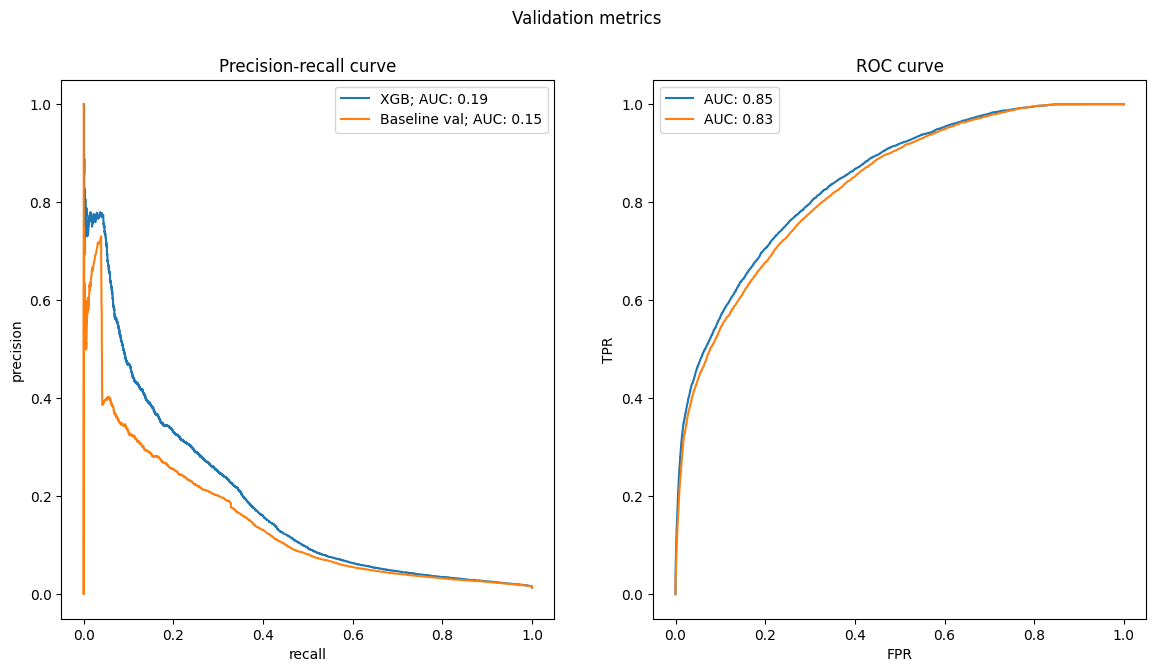

In [137]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")


xg2 = make_pipeline(
    xgb.XGBClassifier(
    objective='binary:logistic',  
    n_estimators=100,            
    max_depth=3,                 
    learning_rate=0.1,         
    subsample=0.8,            
    colsample_bytree=0.8         
)
)

xg2.fit(X_train[top_20_features_xg], y_train)
xg_train_proba2 = xg2.predict_proba(X_train[top_20_features_xg])[:, 1]
plot_metrics(
    f"XGB", y_pred=xg_train_proba2, y_test=train_df[label_col], figure=(fig1,ax1)
)

xg_val_proba2 = xg2.predict_proba(X_val[top_20_features_xg])[:, 1]
plot_metrics(
    f"XGB", y_pred=xg_val_proba2, y_test=val_df[label_col], figure=(fig2,ax2)
)


plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test= train_df[label_col], figure=(fig1, ax1)
)

plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test= val_df[label_col], figure=(fig2, ax2)
)

Si el rendimiento es el mismo, nos interesa tener cuantas menos features mejor, lo que comentaba antes de computacion.

In [ ]:
param_dist = {
    'n_estimators': [50, 100, 200, 300],  
    'max_depth': [3, 5, 7, 9],            
    'learning_rate': [0.01, 0.1, 0.2],   
    'subsample': [0.6, 0.8, 1.0],        
    'colsample_bytree': [0.6, 0.8, 1.0],  
    'reg_alpha': [0, 0.1, 1],             # Regularización L1 (alpha)
    'reg_lambda': [0, 0.1, 1],            # Regularización L2 (lambda)
    'gamma': [0, 0.1, 0.2],               # Reducción mínima de pérdida para dividir un nodo
}

Voy a probar RandomizedSeacrch

In [ ]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  
    scoring='roc_auc',  
    cv=3,               
    n_jobs=-1,       
    verbose=2,        
    random_state=42      
)

In [ ]:
random_search.fit(X_train[train_cols], y_train)


print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor puntuación (AUC-ROC):", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=9, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  13.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=9, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  13.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=9, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  13.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.0s
[CV] END colsample_b

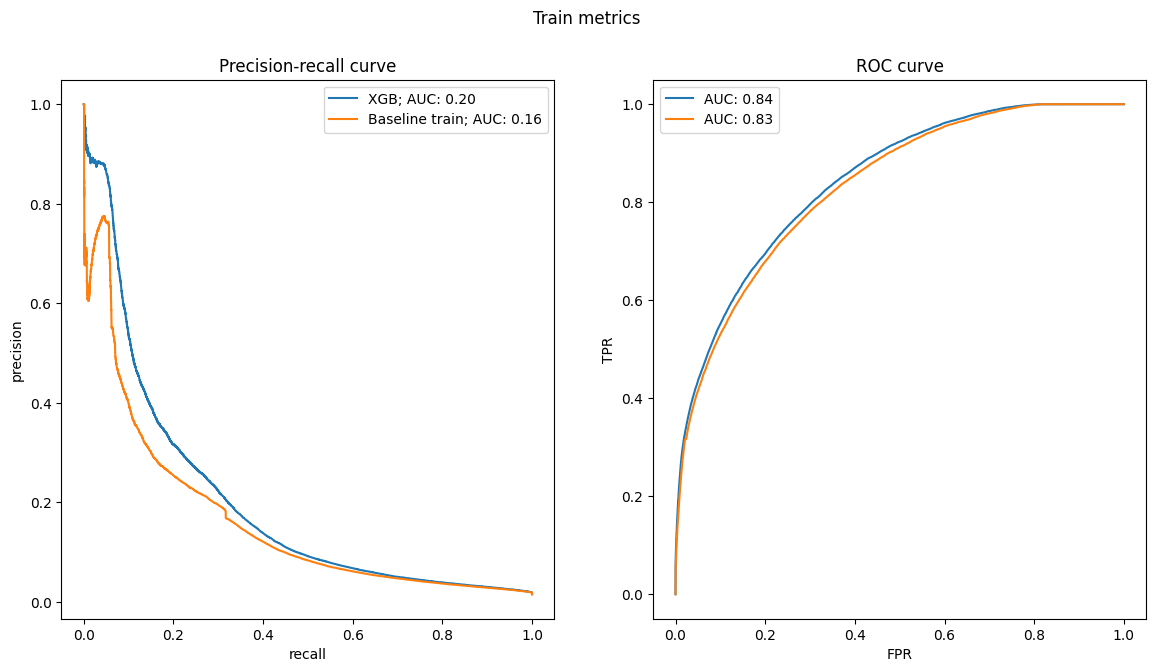

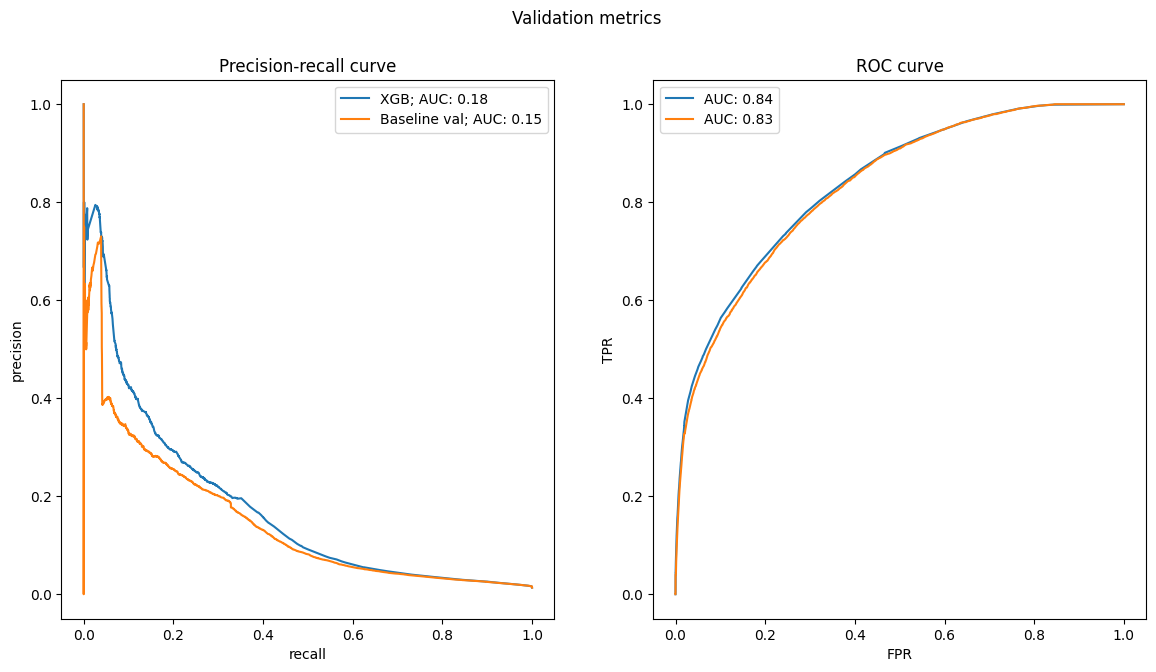

In [139]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")


random_xg = make_pipeline(
    xgb.XGBClassifier(
    objective='binary:logistic',  
    n_estimators=300,            
    max_depth=3,                 
    learning_rate=0.01,         
    subsample=1.0,            
    colsample_bytree=1.0,
    reg_lambda= 0.1,
    reg_alpha=0.1,
    gamma= 0.1        
)
)

random_xg.fit(X_train[train_cols], y_train)
random_xg_train_proba = xg.predict_proba(X_train[train_cols])[:, 1]
plot_metrics(
    f"XGB", y_pred=random_xg_train_proba, y_test=train_df[label_col], figure=(fig1,ax1)
)

random_xg_val_proba = random_xg.predict_proba(X_val[train_cols])[:, 1]
plot_metrics(
    f"XGB", y_pred=random_xg_val_proba, y_test=val_df[label_col], figure=(fig2,ax2)
)


plot_metrics(
    "Baseline train", y_pred=lr_train_proba, y_test= train_df[label_col], figure=(fig1, ax1)
)

plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test= val_df[label_col], figure=(fig2, ax2)
)

Este modelo "mas complejo" tiene peor rendimiento en validación. Pero en resumen, si que XGBoost es el modelo que mejor funciona.

# Comparación de modelos

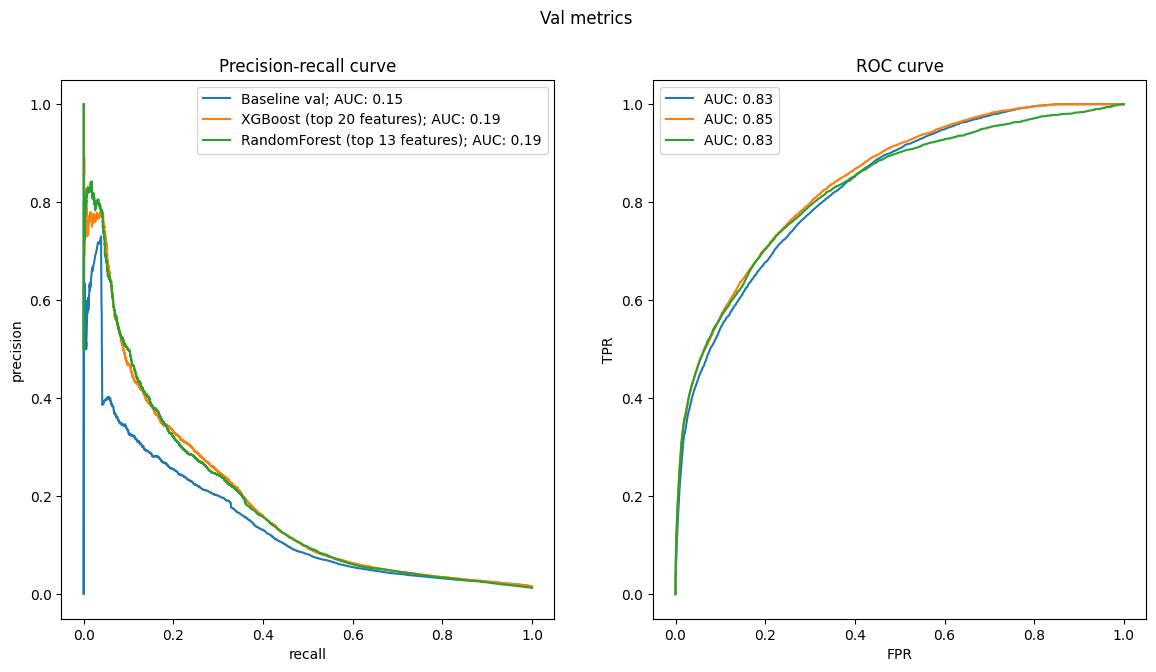

In [146]:

fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Val metrics")


plot_metrics(
    "Baseline val", y_pred=lr_val_proba, y_test= val_df[label_col], figure=(fig1, ax1)
)

plot_metrics(
    "XGBoost (top 20 features)", y_pred=xg_val_proba2, y_test= val_df[label_col], figure=(fig1, ax1)
)

plot_metrics(
    "RandomForest (top 13 features)", y_pred=rf_val_proba, y_test= val_df[label_col], figure=(fig1, ax1)
)


## Mejoras a implementar despues de ver clase

* Investigar como funciona libreria Path

* Tener más en cuenta Feature importance ( en el siguiente modulo se va a ver en profundidad)

* Para mas adelante, pasar el NB a codigo en .py

* Investigar que tipos de Boosting hay y probar

* Al hacer GridSearch, ya que se entrenan varios modelos, mostrar los resultados para cada modelo y poder ver diferencias, en vez de solo entrenar y quedarnos con el mejor con grid_search.best_params_

* Incluir paleta de color que diferencie mejor colores en curvas (daltonicos)


# ¿En que threshold trabajamos viendo las curvas?

Es algo que debemos responder junto al negocio, sabiendo como de costoso es perder usuarios (recall bajo) vs como de costoso es molestar a un usuario con notificación no deseada (precision baja).

En el enunciado se menciona que solo el 5% de las notificaciones push se abren. Este procentaje es la prevalencia base y el objetivo del modelo es mejorar ese %. 

Vamos a asumir que si un usuario esta interesado en un producto, abre la notificación. Nuestro objetivo son los clientes con una probabilidad de interes > 5%, asi mejoramos la prevalencia inicial.

Relacionado con esto Pablo explico el termino de ***calibración***

Cuando hacemos predict_proba, obtenemos un valor entre 0 y 1, que supuestamente es la probabilidad. 

Esto solo ocurre si el modelo esta calibrado, podemos verlo con un plot. 

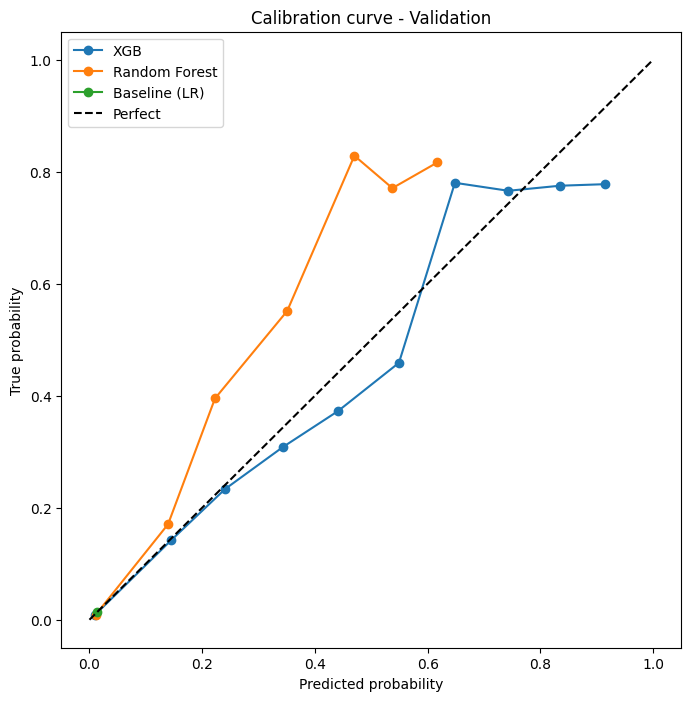

In [155]:
def plot_calibration_curve(models, X, y, title):
    plt.figure(figsize=(8,8))

    for model_name, model_proba in models:
        prob_true, prob_pred = calibration_curve(y, model_proba, n_bins=10)
        plt.plot(prob_pred, prob_true, marker='o', label=model_name)

    #Linea de calibracion perfecta
    plt.plot([0, 1], [0,1], linestyle='--', color='black', label='Perfect')
    plt.xlabel("Predicted probability")
    plt.ylabel("True probability")
    plt.title(title)
    plt.legend()
    plt.show()


models_val = [
    ("XGB", xg_val_proba2),
    ("Random Forest", rf_val_proba),
    ("Baseline (LR)", lr_val_proba),
]

plot_calibration_curve(models_val, X_val, val_df[label_col], "Calibration curve - Validation")



Un modelo estaria calibrado si, el 20% de los puntos que tienen score 0.2, son = 1. 

Por ejemplo para score 0.4, un 40% de los puntos con este score son =1, pero segun Random Forest un 55% de los puntos con score 0.4 tienen etiqueta=1.

XGBoost no es solo el mejor modelo, sino que también esta más calibrado --> Es el modelo con el que me quedo!